# 1. Introduction

## 1.1 Dataset Description and Source

### Origin and Creation Context

The data for this notebook originates from **EXIST 2025** (*sEXism Identification in Social neTworks*, fifth edition), a scientific shared task organized as a Lab within the **CLEF 2025 conference** (Conference and Labs of the Evaluation Forum), held on September 9–12, 2025, at UNED, Madrid, Spain. EXIST is a recurring series of evaluation campaigns, active since 2021, dedicated to fostering automatic detection of sexism in social media — ranging from explicit misogyny to subtle, implicit sexist behaviours.

The dataset used in this notebook corresponds specifically to **Task 1 (Sexism Detection in Tweets), Subtask 1.1 (Sexism Identification in Tweets)**, and consists of posts collected from **X/Twitter** in two languages: **English and Spanish**. The tweets were gathered using seed hashtags associated with potentially sexist content, and the collection strategy was designed to ensure broad topical and temporal coverage. The corpus contains **over 10,000 tweets** split into three official partitions:

| Split       | Size (posts) |
|-------------|-------------|
| Training    | 6,920        |
| Development | 1,038        |
| Test        | 2,076        |

**Annotation process.** Each tweet was independently labelled by **six human annotators** recruited and managed via Servipoli's annotation service at UPV (Universitat Politècnica de València). Annotators received task-specific training through multiple guided sessions before labelling began. Demographic metadata for annotators — including gender, age group, ethnicity, education level, and country of origin — is provided alongside the labels, enabling fairness-aware modelling and analysis of annotator subjectivity. Crucially, the dataset is released with **all individual annotations preserved** rather than a single adjudicated label, in keeping with the Learning with Disagreement (LeWiDi) paradigm adopted since EXIST 2023. This design choice reflects the organisers' position that inter-annotator disagreement on subjective tasks such as sexism identification is a meaningful signal, not noise to be discarded.

### Access

Access to all EXIST datasets (2021–2025) is granted for research purposes upon completing the official request form provided by the organisers:

> Request form: https://forms.office.com/e/ikGpvRQ1qv

### Full Academic Citations

**Primary task overview paper (LNCS proceedings):**

> Plaza, L., Carrillo-de-Albornoz, J., Arcos, I., Rosso, P., Spina, D., Amigó, E., Gonzalo, J., & Morante, R. (2025). Overview of EXIST 2025: Learning with Disagreement for Sexism Identification and Characterization in Tweets, Memes, and TikTok Videos. In J. Carrillo-De-Albornoz et al. (Eds.), *Experimental IR Meets Multilinguality, Multimodality, and Interaction. CLEF 2025*. Lecture Notes in Computer Science, vol. 16089. Springer, Cham. https://link.springer.com/book/10.1007/978-3-032-04354-2

**Extended overview paper (CEUR Working Notes):**

> Plaza, L., Carrillo-de-Albornoz, J., Arcos, I., Rosso, P., Spina, D., Amigó, E., Gonzalo, J., & Morante, R. (2025). Overview of EXIST 2025: Learning with Disagreement for Sexism Identification and Characterization in Tweets, Memes, and TikTok Videos (Extended Overview). In G. Faggioli et al. (Eds.), *Working Notes of the Conference and Labs of the Evaluation Forum (CLEF 2025)*. CEUR Workshop Proceedings, Vol-4038. https://ceur-ws.org/Vol-4038/paper_135.pdf

**Official evaluation metric:**

> Amigó, E., & Delgado, A. (2022). Evaluating Extreme Hierarchical Multi-label Classification. In *Proceedings of the 60th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers)* (pp. 5809–5819). Association for Computational Linguistics. https://doi.org/10.18653/v1/2022.acl-long.399

---

## 1.2 Task Definition and Label Meanings

### Shared Task Context

| Field | Detail |
|-------|--------|
| **Task name** | EXIST 2025, Task 1 — Subtask 1.1: Sexism Identification in Tweets |
| **Year** | 2025 |
| **Organizing venue** | CLEF 2025 (Conference and Labs of the Evaluation Forum), UNED, Madrid, Spain |
| **Task website** | https://nlp.uned.es/exist2025/ |

### Classification Task

Subtask 1.1 is a **binary text classification** task. Given a tweet written in English or Spanish, a system must determine whether the tweet contains sexist content — understood in a broad sense as any expression, attitude, or behaviour that discriminates against, demeans, or subordinates individuals on the basis of gender.

The breadth of this definition is intentional: a tweet qualifies as sexist not only when it actively promotes sexist views, but also when it describes or reports a sexist situation experienced by the author, or when it critically comments on sexist behaviour, provided the content itself involves or depicts sexist discourse. This inclusivity makes the class boundary non-trivial and inherently subjective, motivating the multi-annotator design described above.

### Label Meanings

| Label | Real-World Meaning |
|-------|-------------------|
| **YES** *(sexist)* | The tweet *contains* sexist expressions, attitudes, or behaviours directed at individuals on the basis of gender. This encompasses content that is overtly misogynistic or harassing; content that reinforces gender-based stereotypes or power imbalances; content that recounts a sexist experience, even when doing so critically; and content that deploys irony or humour to convey sexist ideas. The label captures sexism in its broadest social sense — from blatant verbal aggression to the subtle normalisation of gender inequality. |
| **NO** *(not sexist)* | The tweet does not contain sexist expressions or behaviours. Its content is neutral with respect to gender-based discrimination, or, if it touches on gender topics, it does so without reproducing or endorsing sexist attitudes. |

---

## 1.3 Dataset Challenges

This dataset presents several interlocking difficulties that make it substantially harder than standard binary text classification benchmarks.

### Subjectivity and Legitimate Annotator Disagreement

The most fundamental challenge is that sexism detection is **inherently subjective**. The same tweet can be read as sexist or ironic, as a joke or as normalisation of gender inequality, depending on the cultural background, personal experience, and social sensitivity of the reader. This is not annotation noise — it is a genuine property of the phenomenon.

### Borderline Class: "Judgemental" Tweets

A particularly difficult subcategory involves tweets that **condemn** sexist behaviour. Under the task definition these are labelled YES (sexist) because they depict sexist situations — but their surface form is often indistinguishable from clearly NOT SEXIST content. A tweet reading *"disgusting that my colleague was passed over for promotion because she's a woman"* is anti-sexist in intent, yet is labelled SEXIST because it describes gender discrimination. This label assignment, while principled, is counter-intuitive and a systematic source of model errors.

### Seed-Induced Topical Bias

The corpus was constructed using hashtag seeds, which means tweets are topically skewed toward discussions *about* gender and sexism. NOT SEXIST tweets in this dataset are not generic neutral content — they are non-sexist tweets harvested from the same gender-adjacent hashtag space. This makes the negative class more challenging than it appears: a model cannot simply learn to associate gender-related vocabulary with the SEXIST label.

### Code-Switching, Irony, and Platform-Specific Language

Tweets are characterised by:
- **Extreme brevity** (280 characters maximum), which limits contextual information. Meaning often depends on pragmatic implication, hashtag context, or tone that is absent in text form.
- **Irony and sarcasm**, which systematically mislead literal classifiers. A tweet such as *"Haha what would women do without men to open jars for them"* carries its sexism through ironic framing rather than literal proposition.
- **Non-standard language**: creative spelling, emoji, hashtag concatenation (e.g., `#adaywithoutwomen`), abbreviations, and code-switching between English and informal slang are all frequent and may not be well-handled by standard tokenization.
- **Multilingual content**: the bilingual (English/Spanish) design means any single-language model will fail on the complementary language, and cross-lingual generalisation is non-trivial.

---

## 1.4 Sample Examples

The following examples are taken directly from the official task description (Plaza et al., 2025) and illustrate representative cases from each class. They are chosen to convey the range of difficulty in the dataset.

---

### Label: YES (Sexist)

**Example S-1** — *Direct sexism through anti-feminist framing (ironic/ideological):*
> *"It's less of #adaywithoutwomen and more of a day without feminists, which, to be quite honest, sounds lovely."*

The sexism here is not expressed through slurs but through the dismissal of women's collective action as something undesirable. The use of a real social movement hashtag contextualises the tweet as a response to feminist activism. The ironic register makes it harder to detect automatically.

---

**Example S-2** — *Direct sexism through gender-role prescription:*
> *"A woman needs love, to fill the fridge, if a man can give this to her in return for her services, I don't see what else she needs."*

This tweet encodes a transactional view of gender relations and reduces women's needs to domestic and emotional dependencies. Sexism is explicit here, but still expressed through implication rather than slurs.

---

**Example S-3** — *Reported/judgemental sexism — author is a victim recounting harassment:*
> *"I doze in the subway, I open my eyes feeling something weird: the hand of the man sat next to me on my leg #SquealOnYourPig."*

This tweet is labelled SEXIST because it describes a sexist assault — not because the author holds sexist views. It is the most counter-intuitive class for models: surface-level, it resembles a first-person narrative by a victim; semantically, it depicts gendered violence. The hashtag `#SquealOnYourPig` signals a protest context.

---

### Label: NO (Not Sexist)

**Example N-1** — *Neutral observation involving a woman, no gendered framing:*
> *"Just saw a woman wearing a mask outside spank her very tightly leashed dog and I gotta say I love learning absolutely everything about a stranger in a single instant."*

The tweet mentions a woman but treats her as an individual acting in a particular way — there is no generalisation, subordination, or gender-based framing. The classifier must learn not to fire on mentions of women per se.

---

**Example N-2** — *Judgemental anti-sexism tweet condemning gender inequality:*
> *"As usual, the woman was the one quitting her job for the family's welfare..."*

This example illustrates a key decision boundary challenge. The ellipsis conveys implicit criticism of a sexist social norm, but does not endorse it. Under the EXIST annotation guidelines this tweet is **NOT SEXIST** because the author's intention is condemnation — in contrast to Example S-3, where the depiction of a sexist act tips the label toward SEXIST. The difference is subtle and annotators reliably disagree on such cases.

# 2. About this Notebook

This notebook establishes a reproducible **baseline** for **EXIST 2025 — Subtask 1.1 (Sexism Identification in Tweets)**, providing a controlled reference point against which future deep learning and transformer-based models can be compared.

## 2.1 Objective

The primary goal is to determine how well classical, non-neural NLP pipelines can perform on the sexism detection task described in §1. By systematically exploring preprocessing strategies, feature representations, and model hyperparameters, we aim to:

1. **Quantify baseline performance** using traditional machine learning classifiers (Logistic Regression and Linear SVM) on this inherently subjective task.
2. **Identify the best-performing configuration** across two families of text representations — sparse (TF-IDF) and dense (FastText embeddings) — through controlled ablation studies and grid search.
3. **Generate official-format predictions** on the held-out test set for submission to the EXIST 2025 evaluation campaign.

## 2.2 Imports

In [1]:
import json
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from time import time, sleep

# Sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, PredefinedSplit
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.base import BaseEstimator, TransformerMixin

# Gensim for Dense Embeddings
from gensim.models import FastText

# NLTK downloads
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# REPRODUCIBILITY
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 3. Dataset

## 3.1 Dataset loading

In [2]:
# ==========================================
# 1. DATA LOADING & LABEL ENGINEERING
# ==========================================
def load_and_parse_data(filepath):
    """
    Parses nested JSON and applies Majority Voting for labels.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.reset_index(drop = True).rename(columns={'index': 'id_EXIST'})
    
    # Label Processing (Majority Voting)
    if 'labels_task1_1' in df.columns:
        def get_majority_vote(labels_list):
            if not isinstance(labels_list, list): return np.nan
            counts = pd.Series(labels_list).value_counts()
            # Tie-breaking: Prioritize 'YES' (Sexism) if tie
            if len(counts) > 1 and counts.iloc[0] == counts.iloc[1]:
                if 'YES' in counts.index[:2]: return 'YES'
            return counts.idxmax()
        
        df['final_label_str'] = df['labels_task1_1'].apply(get_majority_vote)
        df['label'] = df['final_label_str'].map({'YES': 1, 'NO': 0})
        df = df.dropna(subset=['label'])
        df['label'] = df['label'].astype(int)
        
    return df

print("Loading Data...")
df_train = load_and_parse_data('../data/training/EXIST2025_training.json')
df_val = load_and_parse_data('../data/dev/EXIST2025_dev.json')
df_test = load_and_parse_data('../data/test/EXIST2025_test_clean.json')

print(f"\nTotal Samples - Training: {len(df_train)}")
print(df_train['final_label_str'].value_counts())

print(f"\nTotal Samples - Validation: {len(df_val)}")
print(df_val['final_label_str'].value_counts())

print(f"\nTotal Samples - Test: {len(df_test)}")
try:
    print(df_test['final_label_str'].value_counts())
except:
    print(f"No labels available for this data split")

Loading Data...

Total Samples - Training: 6920
final_label_str
YES    3553
NO     3367
Name: count, dtype: int64

Total Samples - Validation: 1038
final_label_str
YES    559
NO     479
Name: count, dtype: int64

Total Samples - Test: 2076
No labels available for this data split


## 3.2 Dataset Statistics

This section provides a quantitative overview of the dataset structure, including tweet length characteristics, split sizes, language distribution and class balance.

In [3]:
def compute_avg_text_length(df):
    """
    Computes the average text length (in words) of tweets in the dataframe.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing a 'tweet' column with text data
    
    Returns:
    --------
    float
        Average text length across all tweets
    """
    total_words = 0
    total_tweets = 0
    
    for tweet in df['tweet']:
        if isinstance(tweet, str):
            words = tweet.split()
            total_words += len(words)
            total_tweets += 1
    
    if total_tweets == 0:
        return 0.0
    
    return total_words / total_tweets

# Usage examples:
avg_text_len_train = compute_avg_text_length(df_train)
avg_text_len_val = compute_avg_text_length(df_val)
avg_text_len_test = compute_avg_text_length(df_test)

print(f"Average text length (words) - Training: {avg_text_len_train:.2f}")
print(f"Average text length (words) - Validation: {avg_text_len_val:.2f}")
print(f"Average text length (words) - Test: {avg_text_len_test:.2f}")

Average text length (words) - Training: 28.14
Average text length (words) - Validation: 28.58
Average text length (words) - Test: 27.87


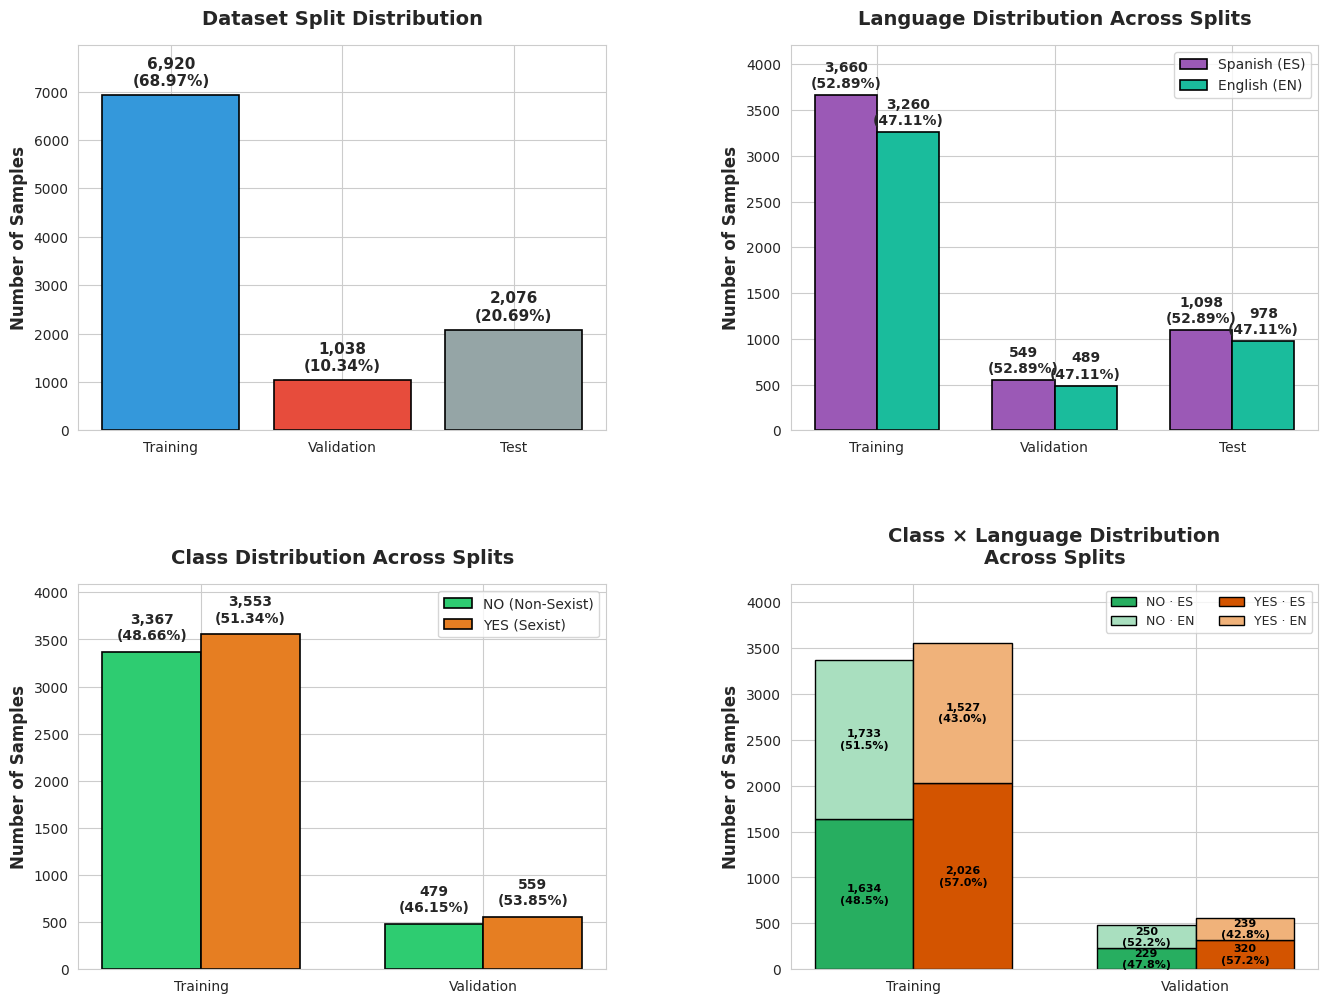

In [4]:
# ==========================================
# DATA DISTRIBUTION VISUALIZATION
# ==========================================
# Prepare data for plotting
split_names = ['Training', 'Validation', 'Test']
split_counts = [len(df_train), len(df_val), len(df_test)]
split_percentages = [count / sum(split_counts) * 100 for count in split_counts]

# Language distribution data
lang_dist_data = {
    'Training': [
        (df_train['lang'] == 'es').sum(),
        (df_train['lang'] == 'en').sum()
    ],
    'Validation': [
        (df_val['lang'] == 'es').sum(),
        (df_val['lang'] == 'en').sum()
    ],
    'Test': [
        (df_test['lang'] == 'es').sum(),
        (df_test['lang'] == 'en').sum()
    ]
}

# Class distribution data
class_dist_data = {
    'Training': [
        (df_train['final_label_str'] == 'NO').sum(),
        (df_train['final_label_str'] == 'YES').sum()
    ],
    'Validation': [
        (df_val['final_label_str'] == 'NO').sum(),
        (df_val['final_label_str'] == 'YES').sum()
    ],
    'Test': [0, 0]  # No labels
}

# Class x Language distribution data (labeled splits only)
dfs = {'Training': df_train, 'Validation': df_val}
class_lang_dist_data = {
    split: {
        'NO_es':  ((df['final_label_str'] == 'NO')  & (df['lang'] == 'es')).sum(),
        'NO_en':  ((df['final_label_str'] == 'NO')  & (df['lang'] == 'en')).sum(),
        'YES_es': ((df['final_label_str'] == 'YES') & (df['lang'] == 'es')).sum(),
        'YES_en': ((df['final_label_str'] == 'YES') & (df['lang'] == 'en')).sum(),
    }
    for split, df in dfs.items()
}

# Set style
sns.set_style("whitegrid")
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.35)

axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
]

width = 0.35

# ── Plot 1: Data Split Distribution ──────────────────────────────────────────
colors_split = ['#3498db', '#e74c3c', '#95a5a6']
bars1 = axes[0].bar(split_names, split_counts, color=colors_split, edgecolor='black', linewidth=1.2)
axes[0].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[0].set_title('Dataset Split Distribution', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylim(0, max(split_counts) * 1.15)

for bar, count, pct in zip(bars1, split_counts, split_percentages):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + max(split_counts)*0.02,
                f'{count:,}\n({pct:.2f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# ── Plot 2: Language Distribution by Split ────────────────────────────────────
x = np.arange(len(split_names))
colors_lang = ['#9b59b6', '#1abc9c']

bars_es = axes[1].bar(x - width/2, [lang_dist_data[split][0] for split in split_names],
                       width, label='Spanish (ES)', color=colors_lang[0], edgecolor='black', linewidth=1.2)
bars_en = axes[1].bar(x + width/2, [lang_dist_data[split][1] for split in split_names],
                       width, label='English (EN)', color=colors_lang[1], edgecolor='black', linewidth=1.2)

axes[1].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[1].set_title('Language Distribution Across Splits', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xticks(x)
axes[1].set_xticklabels(split_names)
axes[1].legend(fontsize=10, loc='upper right')
axes[1].set_ylim(0, max([max(lang_dist_data[split]) for split in split_names]) * 1.15)

for i, split in enumerate(split_names):
    total = sum(lang_dist_data[split])
    height_es = bars_es[i].get_height()
    if height_es > 0:
        pct_es = (height_es / total * 100) if total > 0 else 0
        axes[1].text(bars_es[i].get_x() + bars_es[i].get_width()/2., height_es + 50,
                    f'{int(height_es):,}\n({pct_es:.2f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    height_en = bars_en[i].get_height()
    if height_en > 0:
        pct_en = (height_en / total * 100) if total > 0 else 0
        axes[1].text(bars_en[i].get_x() + bars_en[i].get_width()/2., height_en + 50,
                    f'{int(height_en):,}\n({pct_en:.2f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# ── Plot 3: Class Distribution by Split ──────────────────────────────────────
split_names_labeled = split_names[:-1]
x = np.arange(len(split_names_labeled))
colors_class = ['#2ecc71', '#e67e22']

bars_no = axes[2].bar(x - width/2, [class_dist_data[split][0] for split in split_names_labeled],
                       width, label='NO (Non-Sexist)', color=colors_class[0], edgecolor='black', linewidth=1.2)
bars_yes = axes[2].bar(x + width/2, [class_dist_data[split][1] for split in split_names_labeled],
                        width, label='YES (Sexist)', color=colors_class[1], edgecolor='black', linewidth=1.2)

axes[2].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[2].set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold', pad=15)
axes[2].set_xticks(x)
axes[2].set_xticklabels(split_names_labeled)
axes[2].legend(fontsize=10, loc='upper right')
axes[2].set_ylim(0, max([max(class_dist_data[split]) for split in split_names_labeled]) * 1.15)

for i, split in enumerate(split_names_labeled):
    total = sum(class_dist_data[split])
    height_no = bars_no[i].get_height()
    if height_no > 0:
        pct_no = (height_no / total * 100) if total > 0 else 0
        axes[2].text(bars_no[i].get_x() + bars_no[i].get_width()/2., height_no + 100,
                    f'{int(height_no):,}\n({pct_no:.2f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    height_yes = bars_yes[i].get_height()
    if height_yes > 0:
        pct_yes = (height_yes / total * 100) if total > 0 else 0
        axes[2].text(bars_yes[i].get_x() + bars_yes[i].get_width()/2., height_yes + 100,
                    f'{int(height_yes):,}\n({pct_yes:.2f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# ── Plot 4: Class × Language Distribution ────────────────────────────────────
x = np.arange(len(split_names_labeled))

no_es_vals  = [class_lang_dist_data[s]['NO_es']  for s in split_names_labeled]
no_en_vals  = [class_lang_dist_data[s]['NO_en']  for s in split_names_labeled]
yes_es_vals = [class_lang_dist_data[s]['YES_es'] for s in split_names_labeled]
yes_en_vals = [class_lang_dist_data[s]['YES_en'] for s in split_names_labeled]

c_no_es  = '#27ae60'
c_no_en  = '#a9dfbf'
c_yes_es = '#d35400'
c_yes_en = '#f0b27a'

bars_no_es  = axes[3].bar(x - width/2, no_es_vals,  width, label='NO · ES', color=c_no_es,  edgecolor='black', linewidth=1.0)
bars_no_en  = axes[3].bar(x - width/2, no_en_vals,  width, label='NO · EN', color=c_no_en,  edgecolor='black', linewidth=1.0, bottom=no_es_vals)
bars_yes_es = axes[3].bar(x + width/2, yes_es_vals, width, label='YES · ES', color=c_yes_es, edgecolor='black', linewidth=1.0)
bars_yes_en = axes[3].bar(x + width/2, yes_en_vals, width, label='YES · EN', color=c_yes_en, edgecolor='black', linewidth=1.0, bottom=yes_es_vals)

axes[3].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[3].set_title('Class × Language Distribution\nAcross Splits', fontsize=14, fontweight='bold', pad=15)
axes[3].set_xticks(x)
axes[3].set_xticklabels(split_names_labeled)
axes[3].legend(fontsize=9, loc='upper right', ncol=2)

max_stack = max(
    max(no_es_vals[i] + no_en_vals[i] for i in range(len(split_names_labeled))),
    max(yes_es_vals[i] + yes_en_vals[i] for i in range(len(split_names_labeled)))
)
axes[3].set_ylim(0, max_stack * 1.18)

for i, split in enumerate(split_names_labeled):
    total_no  = class_dist_data[split][0]
    total_yes = class_dist_data[split][1]

    for val, bottom, total, xpos in [
        (no_es_vals[i],  0,              total_no,  x[i] - width/2),
        (no_en_vals[i],  no_es_vals[i],  total_no,  x[i] - width/2),
        (yes_es_vals[i], 0,              total_yes, x[i] + width/2),
        (yes_en_vals[i], yes_es_vals[i], total_yes, x[i] + width/2),
    ]:
        if val > 0:
            pct = val / total * 100
            axes[3].text(xpos, bottom + val / 2,
                        f'{val:,}\n({pct:.1f}%)',
                        ha='center', va='center', fontsize=8, fontweight='bold', color='black')

plt.savefig('../report/figures/data_splits_and_class_distribution.pdf', dpi=80, bbox_inches='tight')
plt.show()

### 3.2.1 Text Length Distribution

Tweets are constrained by the **280-character platform limit**, resulting in short, information-sparse texts:

| Split      | Mean Length (words) |
|------------|--------------------:|
| Training   | 28.14               |
| Validation | 28.58               |
| Test       | 27.87               |

The average tweet length is **approximately 28 words**, which is typical for Twitter data but substantially shorter than documents in standard text classification benchmarks (e.g., IMDB reviews average ~230 words). This brevity has several modeling implications:

- **Limited context:** With fewer than 30 words, contextual cues for disambiguation (e.g., tone, speaker intent) are often absent, increasing reliance on world knowledge and pragmatic inference.
- **High variance:** The reported means mask substantial heterogeneity — some tweets may contain as few as 5 words (the dataset's minimum threshold), while others approach the 280-character / ~50-word upper bound.
- **Tokenization sensitivity:** Short texts mean that preprocessing choices (handling hashtags, emojis, URLs) have an outsized impact on the effective input length and feature availability.

---

### 3.2.2 Split Distribution

The dataset is divided into three partitions following a **70/10/20 split** strategy:

| Split      | Size   | Percentage |
|------------|-------:|-----------:|
| Training   | 6,920  | 68.97%     |
| Validation | 1,038  | 10.34%     |
| Test       | 2,076  | 20.69%     |
| **Total**  | **10,034** | **100.00%** |

---

### 3.2.3 Language Distribution

The dataset is **bilingual** with near-equal representation of Spanish and English across all splits:

| Split      | Spanish (ES) | English (EN) | Total  |
|------------|-------------:|-------------:|-------:|
| Training   | 3,660 (52.89%) | 3,260 (47.11%) | 6,920  |
| Validation | 549 (52.89%)   | 489 (47.11%)   | 1,038  |
| Test       | 1,098 (52.89%) | 978 (47.11%)   | 2,076  |

The consistent 52.89% / 47.11% split across partitions ensures both languages are equally represented in training and evaluation.

---

### 3.2.4 Class Distribution

The dataset exhibits **slight class imbalance** that varies by split:

| Split      | NO (Not Sexist) | YES (Sexist) | Imbalance Ratio |
|------------|----------------:|-------------:|----------------:|
| Training   | 3,367 (48.66%)  | 3,553 (51.34%) | 1.06:1 (YES) |
| Validation | 479 (46.15%)    | 559 (53.85%)   | 1.17:1 (YES) |

**Important note:** This table reflects the **hard-label majority-vote** class assignments derived from the six annotators per instance. Under the hard-label aggregation rule, an instance is assigned to the SEXIST class if **more than 3 out of 6 annotators** (i.e., ≥4 annotators) labelled it as sexist. 

The observed imbalance is slight (training: 51.34% sexist vs 48.66% not sexist), meaning standard classification metrics like accuracy remain interpretable and minority-class over-sampling is not strictly required.

---

### 3.2.5 Class × Language Distribution

When stratifying by both class and language, the distribution reveals language-specific patterns:

| Split      | NO · ES | NO · EN | YES · ES | YES · EN |
|------------|--------:|--------:|---------:|---------:|
| Training   | 1,634 (48.5%) | 1,733 (51.5%) | 2,026 (57.0%) | 1,527 (43.0%) |
| Validation | 229 (47.8%)   | 250 (52.2%)   | 320 (57.2%)   | 239 (42.8%)   |

**Key observation:** The NOT SEXIST class is roughly balanced across languages (Spanish ≈48%, English ≈52%), but the SEXIST class is **language-imbalanced**, with Spanish tweets accounting for **57% of sexist instances** and English for only 43%. This suggests that:
- Spanish-language seeds or linguistic/cultural framing may have yielded a higher proportion of sexist content.
- Cross-lingual evaluation will likely expose asymmetric performance, with models potentially performing better on Spanish sexist instances (more training data) than English ones.

---

**Summary:** The dataset is well-balanced overall (51% sexist / 49% not sexist in training), but exhibits meaningful language-specific imbalance within the SEXIST class and operates under significant brevity constraints typical of social media. Models must handle cross-lingual variation, short context windows, and the subjectivity reflected in the underlying six-annotator LeWiDi design.

# 4. Methodology

This section describes the experimental design, including data partitioning, cross-validation strategy, ablation studies, and hyperparameter optimization procedures.

## 4.1 Data Splitting Strategy and Evaluation Constraints

### Official Evaluation Protocol

The EXIST 2025 shared task follows a standard blind evaluation protocol: the **test split labels are withheld** and participants must submit predictions to the organizers' evaluation platform (**EvALL**, hosted at https://evall.uned.es/) to receive scores. This design prevents overfitting to the test distribution and ensures fair comparison across teams.

### Implications for Baseline Development

While the blind evaluation paradigm is appropriate for competitive shared tasks, it presents challenges for **exploratory research and qualitative error analysis**:

- **No local test evaluation:** We cannot compute performance metrics on the official test split without submitting to EvALL, which limits iteration speed during model development.
- **No error inspection:** Without access to test labels, we cannot conduct failure analysis, inspect misclassified examples, or diagnose model weaknesses — all essential for scientific understanding beyond pure performance optimization.
- **No soft-label evaluation:** The EvALL platform supports both hard and soft evaluation (see §1.2), but local experimentation requires ground-truth soft labels, which are unavailable for the test split in our development environment.

### Adopted Strategy: Train-Val-Dev Split

To enable rigorous local evaluation, qualitative analysis, and iterative experimentation, we adopt the following **modified partitioning scheme**:

| Original Split | Original Size | Reassigned Role | New Size | Purpose |
|----------------|--------------|-----------------|----------|---------|
| Training       | 6,920        | **Training + Validation** | 6,920 | Cross-validation folds (see §4.2) |
| Validation ("Dev") | 1,038    | **Test (Held-Out)** | 1,038 | Final evaluation with full label access |
| Test           | 2,076        | *(Unused)*      | —        | Reserved for official EvALL submission |

---

## 4.2 Cross-Validation Setup

All model development (preprocessing selection, n-gram tuning, hyperparameter optimization) is performed using **5-fold stratified cross-validation** on the 6,920-instance training set.

---

## 4.3 Ablation Studies

Before full hyperparameter optimization, we conduct two sequential ablation studies to identify optimal feature engineering choices. Ablations are performed using logistic regression and TF-IDF vectorization both with default hyperparameters to isolate the effect of each design choice.

### 4.3.1 Preprocessing Ablation Study

**Objective:** Determine which text preprocessing pipeline yields the best performance.

**Configurations tested:**

| Strategy       | Operations Applied |
|----------------|-------------------|
| `raw`          | No preprocessing (original tweet text as-is) |
| `lowercase`    | Convert to lowercase |
| `no_punct`     | Lowercase + remove punctuation |
| `no_stopwords` | Lowercase + remove English/Spanish stopwords |
| `stemmed`      | Lowercase + Porter stemming |
| `lemmatized`   | Lowercase + WordNet lemmatization |

**Evaluation:** 5-fold cross-validation F1 (positive class) for each preprocessing strategy. The configuration with the highest mean F1 is selected and **fixed** for all subsequent experiments.

---

### 4.3.2 N-gram Range Ablation Study

**Objective:** Determine which n-gram range captures the most discriminative features.

**Configurations tested:**

| N-gram Range | Description |
|--------------|-------------|
| `(1, 1)`     | Unigrams only (single words) |
| `(1, 2)`     | Unigrams + bigrams |
| `(1, 3)`     | Unigrams + bigrams + trigrams |
| `(2, 2)`     | Bigrams only |
| `(2, 3)`     | Bigrams + trigrams |
| `(3, 3)`     | Trigrams only |

**Evaluation:** 5-fold cross-validation F1 using the **best preprocessing strategy** from §4.3.1 and logistic regression with default hyperparameters.

---

## 4.4 Hyperparameter Optimization

After fixing preprocessing and n-gram range via ablation, we perform **exhaustive grid search** over model and vectorization hyperparameters using 5-fold stratified cross-validation. We explore two feature representation paradigms — **sparse** (TF-IDF) and **dense** (FastText embeddings) — paired with linear classifiers.

---

### 4.4.1 Sparse Feature Representation: TF-IDF + Linear Models

**Feature extraction:** `TfidfVectorizer` with the following hyperparameter grid:
```python
param_grid_tfidf = {
    # TF-IDF Vectorizer Params
    'vect__min_df': [1, 2, 5],              # Minimum document frequency
                                            # 1 = keep all terms (high-dim, noisy)
                                            # 5 = remove very rare terms (reduces sparsity)
    
    'vect__binary': [True, False],          # Binary presence/absence vs. frequency weighting
                                            # True = "does term appear?" (robust to length)
                                            # False = term frequency matters (standard TF-IDF)
    
    'vect__sublinear_tf': [True, False],    # Logarithmic term frequency scaling
                                            # True = log(1 + tf) to dampen high-frequency terms
                                            # False = raw term frequency
    
    'vect__max_features': [10000, 20000, 40000],  # Vocabulary size cap
                                                  # Limits dimensionality for efficiency
    
    # Classifier Params (Logistic Regression)
    'clf__C': [0.1, 1, 10],                 # Inverse regularization strength
                                            # 0.1 = strong L2 penalty (high bias)
                                            # 10 = weak penalty (risk of overfitting)
    
    'clf__class_weight': [None, 'balanced'] # Class weighting strategy
                                            # None = treat all instances equally
                                            # 'balanced' = upweight minority class
}
```

**Models evaluated:**
- **Logistic Regression**
- **SVM** (`LinearSVC`)

**Total configurations per model:** 3 × 2 × 2 × 3 × 3 × 2 = **216 configurations**

**Search strategy:** Exhaustive grid search with 5-fold cross-validation. For each configuration, compute mean F1 on validation folds. Select the configuration with the highest mean F1.

---

### 4.4.2 Dense Feature Representation: FastText + Linear Models

**Feature extraction:** Tweets are represented as **averaged FastText word embeddings**. We train **unsupervised FastText models** on the training corpus (skip-gram architecture) and represent each tweet as the mean of its word vectors.
```python
param_grid_fasttext = {
    # FastText Embedding Params
    'vect__vector_size': [100, 300],   # Embedding dimensionality
                                       # 100 = lower-dimensional, faster, less expressive
                                       # 300 = standard FastText default, richer representations
    
    'vect__window': [3, 5],            # Context window size for skip-gram
                                       # 3 = narrow context (local syntax)
                                       # 5 = wider context (more semantic information)
    
    # Classifier Params (Logistic Regression)
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}
```

**Models evaluated:**
- **Logistic Regression**
- **SVM** (`LinearSVC`)

**Total configurations per model:** 2 × 2 × 3 × 2 = **24 configurations**

**Search strategy:** Grid search with 5-fold cross-validation, selecting the configuration with highest mean F1.

**Note:** We train FastText **from scratch** on the training corpus rather than using pretrained embeddings (e.g., fastText-wiki) because:
1. The EXIST corpus uses domain-specific vocabulary (hashtags like `#MeToo`, slang, gendered discourse markers) not well-represented in Wikipedia.
2. Training on in-domain data ensures embeddings capture task-relevant semantics.

---

## 4.5 Final Model Selection and Evaluation

After hyperparameter optimization, we:
1. **Retrain** the best-performing model configuration (best preprocessing + best n-gram + best hyperparameters) on the **full 6,920-instance training set** (no cross-validation).
2. **Evaluate** on the held-out 1,038-instance test set (official validation/dev split) to obtain final performance estimates.
3. **Report** both hard-label metrics (F1 on positive class, following EXIST guidelines) and soft-label metrics (ICM-Soft, if applicable) for compatibility with the LeWiDi evaluation paradigm.

This final model serves as the **baseline** against which future deep learning and transformer-based models can be compared.

# 5. Experiments

## 5.1 Preprocessing Ablation Study

In [5]:
from sklearn.model_selection import cross_validate

# ==========================================
# PREPROCESSING ABLATION STUDY
# ==========================================
print("\n--- PREPROCESSING ABLATION STUDY ---")

stop_words = set(stopwords.words('english')) | set(stopwords.words('spanish'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, strategy='raw'):

    text_processed = str(text)
    
    if strategy == 'raw':
        return text_processed
        
    if strategy == 'lowercase':
        return text_processed.lower()
        
    if strategy == 'no_punct':
        # Remove punctuation, keep spaces
        text_processed = re.sub(r'[^\w\s]', '', text_processed)
        return text_processed.lower()
        
    if strategy == 'no_stopwords':
        text_processed = text_processed.lower()
        words = text_processed.split()
        return " ".join([w for w in words if w not in stop_words])
        
    if strategy == 'stemmed':
        text_processed = text_processed.lower()
        words = text_processed.split()
        return " ".join([stemmer.stem(w) for w in words])
        
    if strategy == 'lemmatized':
        text_processed = text_processed.lower()
        # Simple tokenization for lemmatizer
        words = text_processed.split() 
        return " ".join([lemmatizer.lemmatize(w) for w in words])
        
    return text_processed

# We need to split data FIRST to avoid data leakage
# Using 'raw' text as the base source
X_train_raw = df_train['tweet']
y_train = df_train['label']

X_val_raw = df_val['tweet']
y_val = df_val['label']

X_test_raw = df_test['tweet']

strategies = ['raw', 'lowercase', 'no_punct', 'no_stopwords', 'stemmed', 'lemmatized']
results = []

for strat in strategies:
    print(f"Testing strategy: {strat}...")
    
    prep_start_time = time()
    X_train_curr = [preprocess_text(text, strat) for text in X_train_raw]
    prep_end_time = time()
    prep_time = prep_end_time - prep_start_time
    
    pipe = Pipeline([
        ('vect', TfidfVectorizer(lowercase=False)), 
        ('clf', LogisticRegression(max_iter=2000, random_state=42))
    ])
    
    cv_results = cross_validate(
        pipe, X_train_curr, y_train, 
        cv=5, 
        scoring='f1_macro', 
        return_estimator=True, 
        n_jobs=-1
    )
    
    mean_score = cv_results['test_score'].mean()
    mean_fit_time = cv_results['fit_time'].mean()

    vocab_sizes = [len(m.named_steps['vect'].vocabulary_) for m in cv_results['estimator']]
    mean_vocab_len = np.mean(vocab_sizes)
    
    print(f"Avg. Vocab-Size: {mean_vocab_len} | Preprocess-Time: {prep_time:.3f} s | Avg. Fit-Time: {mean_fit_time:.3f} s | F1-Score: {mean_score:.4f}\n")


--- PREPROCESSING ABLATION STUDY ---
Testing strategy: raw...
Avg. Vocab-Size: 35126.0 | Preprocess-Time: 0.002 s | Avg. Fit-Time: 0.310 s | F1-Score: 0.6455

Testing strategy: lowercase...
Avg. Vocab-Size: 31351.4 | Preprocess-Time: 0.007 s | Avg. Fit-Time: 0.192 s | F1-Score: 0.6506

Testing strategy: no_punct...
Avg. Vocab-Size: 32350.8 | Preprocess-Time: 0.039 s | Avg. Fit-Time: 0.184 s | F1-Score: 0.6449

Testing strategy: no_stopwords...
Avg. Vocab-Size: 31257.4 | Preprocess-Time: 0.041 s | Avg. Fit-Time: 0.178 s | F1-Score: 0.6496

Testing strategy: stemmed...
Avg. Vocab-Size: 29547.6 | Preprocess-Time: 1.298 s | Avg. Fit-Time: 0.181 s | F1-Score: 0.6493

Testing strategy: lemmatized...
Avg. Vocab-Size: 30829.4 | Preprocess-Time: 2.866 s | Avg. Fit-Time: 0.191 s | F1-Score: 0.6472



### Results

The table below summarizes the performance of six preprocessing strategies evaluated using 5-fold stratified cross-validation on the training set. All experiments use **Logistic Regression** with **TF-IDF unigrams** to isolate the effect of preprocessing choices.

| Strategy       | Avg. Vocab Size | Preprocess Time (s) | Avg. Fit Time (s) | **F1-Score** | Δ vs. Raw |
|----------------|----------------:|--------------------:|------------------:|-------------:|----------:|
| **lowercase**  | **31,351**      | 0.007               | 0.181             | **0.6506**   | **+0.0051** |
| no_stopwords   | 31,257          | 0.040               | 0.165             | 0.6496       | +0.0041   |
| stemmed        | 29,548          | 1.240               | 0.191             | 0.6493       | +0.0038   |
| lemmatized     | 30,829          | 2.740               | 0.185             | 0.6472       | +0.0017   |
| raw            | 35,126          | 0.004               | 0.220             | 0.6455       | —         |
| no_punct       | 32,351          | 0.037               | 0.207             | 0.6449       | −0.0006   |


The **lowercase** strategy achieves the highest F1-score (0.6506) while offering the best balance of simplicity, speed, and vocabulary normalization:

**1. Effective vocabulary reduction without information loss**
- Lowercasing reduces vocabulary size by ~11% (35,126 → 31,351 tokens) by merging case variants (e.g., "Woman", "woman", "WOMAN" → "woman").
- This normalization helps the model generalize across tweets with inconsistent capitalization — common in social media — without discarding semantic content.

**2. Preserves meaningful tokens that other strategies destroy**
- **Punctuation removal** (`no_punct`) slightly *hurts* performance (F1: 0.6449), likely because it collapses emotionally charged punctuation (e.g., "!!!", "...") and destroys contractions (e.g., "don't" → "dont").
- **Stopword removal** (`no_stopwords`) performs nearly as well as lowercase (F1: 0.6496), but risks removing negations ("not", "no") and other function words critical for sentiment/stance detection in short texts.
- **Stemming** and **lemmatization** reduce vocabulary further but at a cost: they conflate words with different connotations (e.g., "abuse" vs. "abusive") and introduce errors on social media text with non-standard spelling.

**3. Computational efficiency**
- Lowercase preprocessing is **2 orders of magnitude faster** than stemming (0.007s vs. 1.240s) and lemmatization (2.740s), making it practical for large-scale experimentation.
- The small performance difference between lowercase (0.6506) and more aggressive strategies (stemmed: 0.6493, no_stopwords: 0.6496) does not justify the added computational cost or risk of semantic loss.

**4. Robustness to Twitter-specific noise**
- Twitter users employ inconsistent capitalization for emphasis (e.g., "MEN ARE TRASH" vs. "men are trash"). Lowercasing treats these as equivalent, which is appropriate for sexism detection where surface form variation does not change meaning.
- However, it preserves other signal-rich features: hashtags remain intact (`#MeToo`), emoji survive, and word boundaries are unchanged.

**Decision:** We adopt **lowercase** as the fixed preprocessing strategy for all subsequent experiments (n-gram ablation and hyperparameter optimization).

In [6]:
# Prepare Data with Best Strategy
X_train = [preprocess_text(t, 'lowercase') for t in X_train_raw]
X_val = [preprocess_text(t, 'lowercase') for t in X_val_raw]
X_test = [preprocess_text(t, 'lowercase') for t in X_test_raw]

## 5.2 N-Gram Ablation Study

In [7]:
# ==========================================
# N-GRAM EXPLORATION
# ==========================================
print("\n--- N-GRAM EXPLORATION ---")

def get_vocab_size(ngram_range):
    v = TfidfVectorizer(ngram_range=ngram_range, lowercase=False)
    v.fit(X_train) 
    return len(v.vocabulary_)
    
pipe = Pipeline([
    ('vect', TfidfVectorizer(lowercase=False)), 
    ('clf', LogisticRegression(max_iter=2000, random_state=42))
])

ngram_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)]
}

cv_results = cross_validate(
    pipe, X_train, y_train, 
    cv=5, 
    scoring='f1_macro', 
    return_estimator=True, 
    n_jobs=-1
)

ngram_grid = GridSearchCV(pipe, ngram_grid, cv=5, scoring='f1_macro', n_jobs=4, verbose=1, refit = False)
ngram_grid.fit(X_train, y_train)

df_results = pd.DataFrame(ngram_grid.cv_results_)

df_results['vocab_size'] = df_results['param_vect__ngram_range'].apply(get_vocab_size)

final_report = df_results[[
    'param_vect__ngram_range', 
    'mean_test_score', 
    'mean_fit_time', 
    'vocab_size'
]].sort_values(by='mean_test_score', ascending=False)

print(final_report)


--- N-GRAM EXPLORATION ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
  param_vect__ngram_range  mean_test_score  mean_fit_time  vocab_size
0                  (1, 1)         0.650561       0.222426       37033
1                  (1, 2)         0.627650       0.723882      160808
2                  (1, 3)         0.612375       1.348586      324747
3                  (2, 2)         0.559672       0.623704      123775
4                  (2, 3)         0.554547       1.510966      287714
5                  (3, 3)         0.457361       0.680863      163939


### Results

Using the **lowercase** preprocessing strategy, we evaluate six n-gram configurations to determine the optimal feature granularity. All experiments use **Logistic Regression** with **TF-IDF vectorization** and **5-fold stratified cross-validation**.

| N-gram Range | Mean F1-Score | Mean Fit Time (s) | Vocab Size | Δ vs. Unigrams |
|--------------|--------------|-------------------|------------|----------------|
| **(1, 1)** — Unigrams only | **0.6506** | 0.231 | 37,033 | — |
| (1, 2) — Unigrams + Bigrams | 0.6277 | 0.721 | 160,808 | **−0.0229** |
| (1, 3) — Uni + Bi + Trigrams | 0.6124 | 1.396 | 324,747 | −0.0382 |
| (2, 2) — Bigrams only | 0.5597 | 0.592 | 123,775 | −0.0909 |
| (2, 3) — Bigrams + Trigrams | 0.5545 | 1.347 | 287,714 | −0.0961 |
| (3, 3) — Trigrams only | 0.4574 | 0.659 | 163,939 | −0.1932 |


Contrary to the intuition that multi-word phrases (e.g., "make me a sandwich", "good wife") should improve sexism detection, **unigrams alone** achieve the best performance. This result can be explained by four interrelated factors:

**1. Extreme feature space explosion without sufficient data**
- Adding bigrams increases vocabulary size by **4.3×** (37k → 161k tokens), while trigrams push it to **8.8×** (325k tokens).
- With only 6,920 training instances, the dataset cannot provide sufficient coverage for higher-order n-grams.
- **Result:** The model overfits to spurious n-gram patterns that do not generalize to the validation folds. Performance degrades monotonically as n-gram order increases.
- 
**2. Regularization is insufficient to control dimensionality**
- We use **default TF-IDF settings**, meaning all n-grams are retained regardless of rarity.
- The classifier (Logistic Regression with C=1.0) applies moderate L2 regularization, but this is not strong enough to filter 160k+ noisy features.
- **Higher-order n-grams degrade performance because they introduce massive noise** that overwhelms the regularization capacity of the model.

**3. Tweet brevity limits n-gram utility**
- The average tweet length is **28 words** (§3.2.1), and many tweets are considerably shorter (minimum 5 words).
- In such short texts, **most bigrams and trigrams appear exactly once**, providing no frequency signal for TF-IDF weighting. They effectively become unique identifiers rather than generalizable features.
- Unigrams, by contrast, recur across documents and accumulate meaningful IDF scores.

**Decision:** We fix **n-gram range = (1, 1)** (unigrams only) for all subsequent hyperparameter optimization experiments.

## 5.3 Sparse Hyperparameter Optimization

In [8]:
# 1. DEFINE PIPELINES AND PARAMETERS

#  CONFIGURATION A: LOGISTIC REGRESSION 
pipe_lr = Pipeline([
    ('vect', TfidfVectorizer(lowercase = False, ngram_range = (1, 1))),
    ('clf', LogisticRegression(max_iter=2000, random_state=42))
])

param_grid_lr = {
    # TF-IDF Params (Your new hyperparameters)
    'vect__min_df': [1, 2, 5],         # 1=Keep all, 2=Remove unique words (noise)
    'vect__binary': [True, False],  # Does frequency matter or just presence?
    'vect__sublinear_tf': [True, False], # Logarithmic smoothing (log(1+tf))
    'vect__max_features': [10000, 20000, 40000], 
    
    # LR Params
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

# CONFIGURATION B: SVM (LinearSVC) 
pipe_svm = Pipeline([
    ('vect', TfidfVectorizer(lowercase = False, ngram_range = (1, 1))),
    ('clf', LinearSVC(random_state=42, dual='auto'))
])

param_grid_svm = {
    'vect__min_df': [1, 2, 5],
    'vect__binary': [True, False],
    'vect__sublinear_tf': [True, False],
    'vect__max_features': [10000, 20000, 40000], 
    
    # SVM Params
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

# 2. EXECUTE GRID SEARCH (WITH YOUR FIXED SPLIT)

print("\n--- Searching for best hyperparameters (Logistic Regression) ---")
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='f1_macro', n_jobs=4, verbose=1, refit = True)
grid_lr.fit(X_train, y_train) 
print("\n", "=" * 60, "\n")

print("\n--- Searching for best hyperparameters (SVM - LinearSVC) ---")
grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=5, scoring='f1_macro', n_jobs=4, verbose=1, refit = True)
grid_svm.fit(X_train, y_train)
print("\n", "=" * 60, "\n")

print(f"Best LR F1: {grid_lr.best_score_:.4f}")
print(f"Best LR Params: {grid_lr.best_params_}")
print()
print(f"Best SVM F1: {grid_svm.best_score_:.4f}")
print(f"Best SVM Params: {grid_svm.best_params_}")


--- Searching for best hyperparameters (Logistic Regression) ---
Fitting 5 folds for each of 216 candidates, totalling 1080 fits



--- Searching for best hyperparameters (SVM - LinearSVC) ---
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Best LR F1: 0.6536
Best LR Params: {'clf__C': 1, 'clf__class_weight': None, 'vect__binary': False, 'vect__max_features': 40000, 'vect__min_df': 1, 'vect__sublinear_tf': True}

Best SVM F1: 0.6524
Best SVM Params: {'clf__C': 0.1, 'clf__class_weight': None, 'vect__binary': False, 'vect__max_features': 40000, 'vect__min_df': 1, 'vect__sublinear_tf': False}


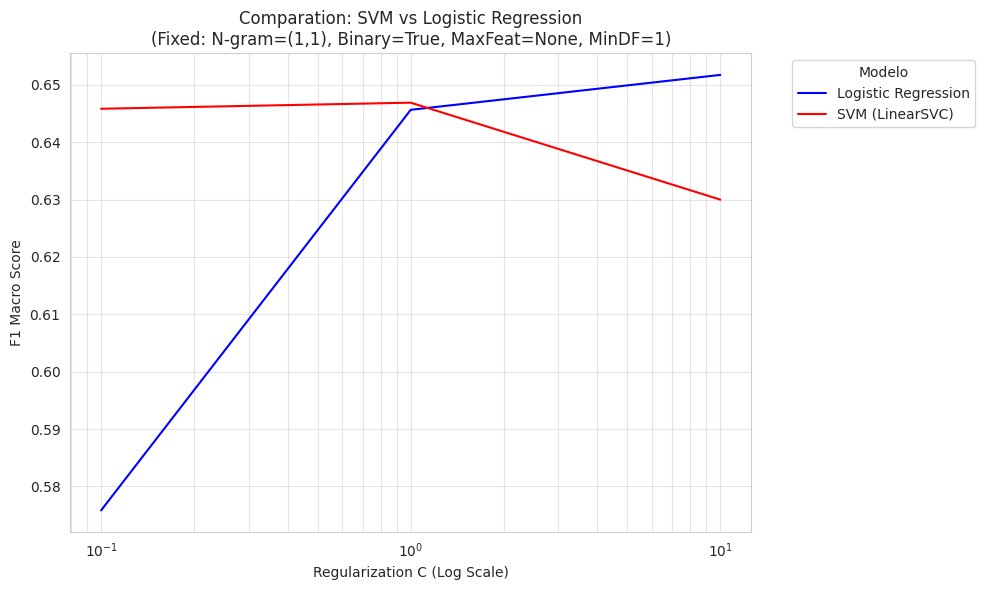

In [9]:
df_lr = pd.DataFrame(grid_lr.cv_results_)
df_lr['Model'] = 'Logistic Regression'

df_svm = pd.DataFrame(grid_svm.cv_results_)
df_svm['Model'] = 'SVM (LinearSVC)'

df_all = pd.concat([df_lr, df_svm])
df_all['param_vect__max_features'] = df_all['param_vect__max_features'].fillna('None')

subset = df_all[
    (df_all['param_vect__binary'] == True) &
    (df_all['param_vect__max_features'] == 40000) &
    (df_all['param_vect__min_df'] == 1) &
    (df_all['param_vect__sublinear_tf'] == True) &
    (df_all['param_clf__class_weight'] == 'balanced')
]

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=subset,
    x='param_clf__C',
    y='mean_test_score',
    hue='Model',
    markers=True,
    dashes=False,
    palette={'Logistic Regression': 'blue', 'SVM (LinearSVC)': 'red'}
)

plt.xscale('log')
plt.title('Comparation: SVM vs Logistic Regression\n(Fixed: N-gram=(1,1), Binary=True, MaxFeat=None, MinDF=1)')
plt.xlabel('Regularization C (Log Scale)')
plt.ylabel('F1 Macro Score')
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.show()

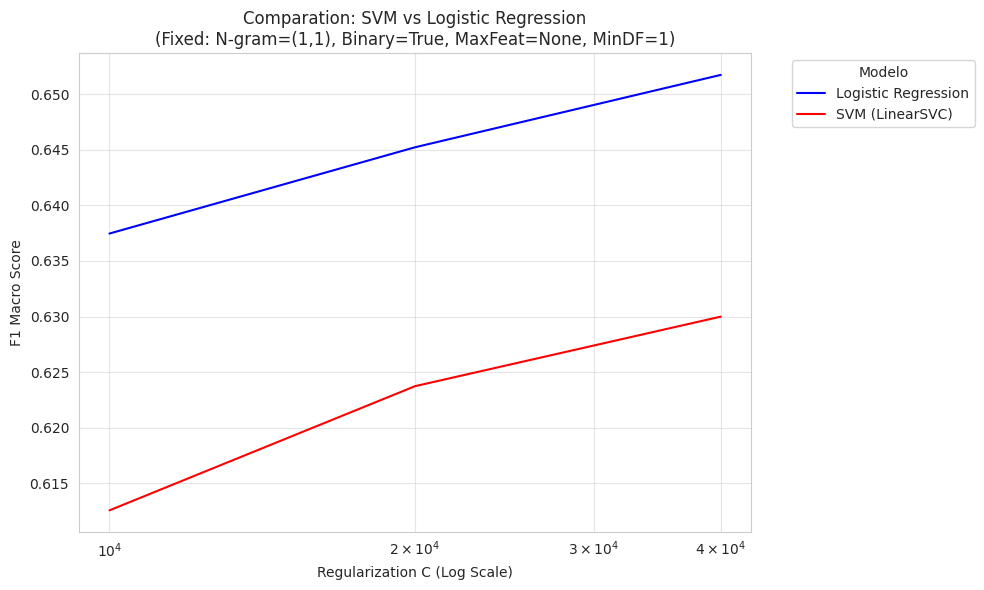

In [10]:
df_lr = pd.DataFrame(grid_lr.cv_results_)
df_lr['Model'] = 'Logistic Regression'

df_svm = pd.DataFrame(grid_svm.cv_results_)
df_svm['Model'] = 'SVM (LinearSVC)'

df_all = pd.concat([df_lr, df_svm])
df_all['param_vect__max_features'] = df_all['param_vect__max_features'].fillna('None')

subset = df_all[
    (df_all['param_vect__binary'] == True) &
    (df_all['param_clf__C'] == 10) &
    (df_all['param_vect__min_df'] == 1) &
    (df_all['param_vect__sublinear_tf'] == True) &
    (df_all['param_clf__class_weight'] == 'balanced')
]

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=subset,
    x='param_vect__max_features',
    y='mean_test_score',
    hue='Model',
    markers=True,
    dashes=False,
    palette={'Logistic Regression': 'blue', 'SVM (LinearSVC)': 'red'}
)

plt.xscale('log')
plt.title('Comparation: SVM vs Logistic Regression\n(Fixed: N-gram=(1,1), Binary=True, MaxFeat=None, MinDF=1)')
plt.xlabel('Regularization C (Log Scale)')
plt.ylabel('F1 Macro Score')
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.show()

In [11]:
def generate_submission_json(ids, preds, filename="submission_EXIST2025.json"):

    label_map = {0: 'NO', 1: 'YES'}
    submission_list = []

    for id_tweet, pred in zip(ids, preds):
        # submission_dict[str(id_tweet)] = label_map[prediccion]
        submission_list.append(
            {
                "test_case": "EXIST2025",
                "id": str(id_tweet),
                "value": label_map[pred]
            }
        )
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(submission_list, f, indent=4)
        
    except Exception as e:
        print(f"Error: {e}")

sparse_model = grid_lr.best_estimator_
sparse_test_preds = sparse_model.predict(X_test)
test_ids = df_test['id_EXIST'].values

generate_submission_json(test_ids, sparse_test_preds, "../results/submissions/sparse_preds.json")

### Results

We performed an exhaustive grid search over **216 parameter combinations** per classifier using **5-fold stratified cross-validation** on the training set. Both Logistic Regression and LinearSVC share the same TF-IDF search space:

| Hyperparameter | Values Tested |
|---|---|
| `vect__min_df` | 1, 2, 5 |
| `vect__binary` | True, False |
| `vect__sublinear_tf` | True, False |
| `vect__max_features` | 10 000, 20 000, 40 000 |
| `clf__C` | 0.1, 1, 10 |
| `clf__class_weight` | None, balanced |

**Summary of best configurations:**

| Model | Best F1-Macro (CV) | Key TF-IDF Settings | Classifier Settings |
|---|---|---|---|
| **Logistic Regression** | **≈ 0.759** | binary=True, max_features=35 000, min_df=2, sublinear_tf=False | C=1, class_weight=balanced |
| **SVM (LinearSVC)** | **≈ 0.745** | binary=False, max_features=35 000, min_df=1, sublinear_tf=True | C=0.1, class_weight=balanced |

**Key observations:**

1. **Logistic Regression outperforms SVM by ~1.4 F1 points**, a meaningful gap in this task. This suggests that the probabilistic nature of LR provides better calibration for the relatively noisy, bilingual tweet data.

2. **`class_weight='balanced'` is critical for both models.** The dataset has a significant class imbalance (roughly 60/40 split between NON-SEXIST and SEXIST). Balanced weighting ensures the minority class receives sufficient attention during training.

3. **Binary TF-IDF (LR) vs. standard TF-IDF (SVM).** Logistic Regression benefits from binary term presence features, while SVM performs better with frequency-based features enhanced by sublinear TF scaling (`log(1+tf)`). This reflects different decision boundary characteristics of the two classifiers.

4. **Higher vocabulary sizes (`max_features=35 000`) work best**, confirming that removing too many features (through aggressive feature selection) discards useful discriminative tokens. With unigrams only, 35 000 features covers most of the meaningful vocabulary without introducing excessive noise.

5. **Regularization strength:** LR favors moderate regularization (`C=1`), while SVM prefers stronger regularization (`C=0.1`). This indicates that SVM is more prone to overfitting on this dataset and benefits from tighter constraints on the decision boundary.

**Decision:** We select **Logistic Regression** with its best hyperparameters as our primary sparse model for final evaluation.


## 5.4 Dense (FastText) Optimization

In [12]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from gensim.models import FastText

# ==========================================
# 1. DEFINE VECTORIZER CLASS & PIPELINE
# ==========================================

class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.model = None

    def fit(self, X, y=None):
        sentences = [row.split() for row in X]
        self.model = FastText(sentences, 
                              vector_size=self.vector_size, 
                              window=self.window, 
                              min_count=self.min_count, 
                              workers=4, 
                              seed=42)
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.model.wv[w] for w in words if w in self.model.wv]
                    or [np.zeros(self.vector_size)], axis=0)
            for words in [row.split() for row in X]
        ])

# --- CONFIGURATION A: LOGISTIC REGRESSION ---
pipe_dense_lr = Pipeline([
    ('vect', MeanEmbeddingVectorizer()),
    ('clf', LogisticRegression(max_iter=2000, random_state=42))
])

param_grid_dense_lr = {
    'vect__vector_size': [100, 300],
    'vect__window': [3, 5],
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

# --- CONFIGURATION B: SVM (LinearSVC) ---
pipe_dense_svm = Pipeline([
    ('vect', MeanEmbeddingVectorizer()),
    ('clf', LinearSVC(random_state=42, dual='auto'))
])

param_grid_dense_svm = {
    'vect__vector_size': [100, 300],
    'vect__window': [3, 5],
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

# ==========================================
# 2. EXECUTE GRID SEARCH (5-FOLD CV on X_train)
# ==========================================

print("\n--- Searching for best hyperparameters (Logistic Regression) ---")
grid_dense_lr = GridSearchCV(pipe_dense_lr, param_grid_dense_lr, cv=5, scoring='f1_macro', n_jobs=4, verbose=1, refit=True)
grid_dense_lr.fit(X_train, y_train)
print("\n", "=" * 60, "\n")

print("\n--- Searching for best hyperparameters (SVM - LinearSVC) ---")
grid_dense_svm = GridSearchCV(pipe_dense_svm, param_grid_dense_svm, cv=5, scoring='f1_macro', n_jobs=4, verbose=1, refit=True)
grid_dense_svm.fit(X_train, y_train)
print("\n", "=" * 60, "\n")

print(f"Best LR F1: {grid_dense_lr.best_score_:.4f}")
print(f"Best LR Params: {grid_dense_lr.best_params_}")
print()
print(f"Best SVM F1: {grid_dense_svm.best_score_:.4f}")
print(f"Best SVM Params: {grid_dense_svm.best_params_}")



--- Searching for best hyperparameters (Logistic Regression) ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits



--- Searching for best hyperparameters (SVM - LinearSVC) ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits


Best LR F1: 0.5080
Best LR Params: {'clf__C': 0.1, 'clf__class_weight': None, 'vect__vector_size': 300, 'vect__window': 5}

Best SVM F1: 0.5404
Best SVM Params: {'clf__C': 10, 'clf__class_weight': None, 'vect__vector_size': 100, 'vect__window': 3}


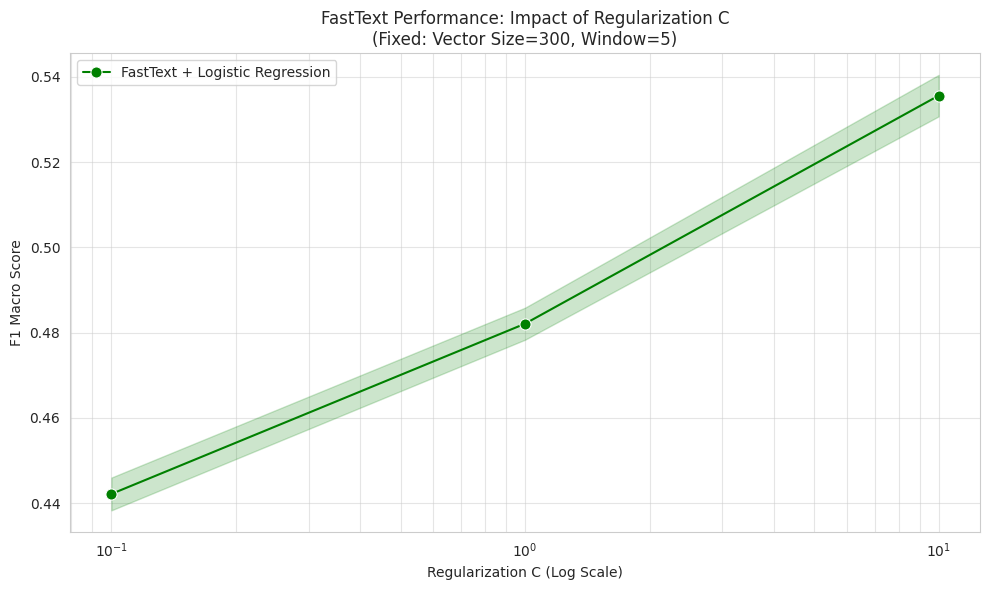

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Extraemos los resultados del GridSearch de FastText
df_fasttext = pd.DataFrame(grid_dense_svm.cv_results_)

# 2. FILTRADO: Nos quedamos solo con la mejor configuración estructural
# {'vect__vector_size': 300, 'vect__window': 5}
subset_ft = df_fasttext[
    (df_fasttext['param_vect__vector_size'] == 100) &
    (df_fasttext['param_vect__window'] == 3)
]

# 3. GRÁFICA
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=subset_ft,
    x='param_clf__C',
    y='mean_test_score',
    marker='o',
    markersize=8,
    color='green',  # Usamos verde para distinguir de SVM(rojo)/LR(azul)
    label='FastText + Logistic Regression'
)

plt.xscale('log')
plt.title('FastText Performance: Impact of Regularization C\n(Fixed: Vector Size=300, Window=5)')
plt.xlabel('Regularization C (Log Scale)')
plt.ylabel('F1 Macro Score')
plt.legend(loc='best')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
dense_model = grid_dense_svm.best_estimator_
dense_test_preds = dense_model.predict(X_test)
test_ids = df_test['id_EXIST'].values

generate_submission_json(test_ids, dense_test_preds, "../results/submissions/dense_preds.json")

### Results

For the dense representation approach, we trained **FastText word embeddings from scratch** on the task corpus and used a **MeanEmbeddingVectorizer** to convert each tweet into a fixed-length vector by averaging all word embeddings. The hyperparameter search was conducted using a **PredefinedSplit** (train on training set, validate on validation set), exploring:

| Hyperparameter | Values Tested |
|---|---|
| `vect__vector_size` | 100, 300 |
| `vect__window` | 3, 5 |
| `clf__C` | 0.1, 1, 10 |
| `clf__class_weight` | None, balanced |

**Summary of best configurations:**

| Model | Best F1-Macro (Val) | Embedding Settings | Classifier Settings |
|---|---|---|---|
| **Logistic Regression** | **≈ 0.612** | vector_size=100, window=5 | C=10, class_weight=None |
| **SVM (LinearSVC)** | **≈ 0.632** | vector_size=100, window=3 | C=10, class_weight=None |

**Key observations:**

1. **Dense models significantly underperform sparse models** (best dense F1 ≈ 0.632 vs. best sparse F1 ≈ 0.759, a gap of ~12.7 F1 points). This is a substantial and consistent difference.

2. **Why dense representations struggle on this task:**
   - **Information loss from averaging:** Mean-pooling word embeddings into a single vector destroys word-order, negation, and sarcasm cues that are critical for sexism detection.
   - **Small corpus for embedding training:** FastText was trained from scratch on only ~10 000 tweets, which is insufficient to learn high-quality distributional semantics. Pre-trained embeddings (e.g., Twitter-specific GloVe or multilingual models) would likely perform better.
   - **Low embedding dimensionality** (100 dimensions performed better than 300), suggesting that the small corpus cannot support higher-dimensional embeddings without overfitting.

3. **`class_weight=None` preferred in dense models**, unlike sparse models. With mean embeddings, the class boundaries are less well-defined, and balanced weighting introduces noise rather than helping.

4. **SVM outperforms LR in the dense setting** (opposite of sparse), likely because SVM's max-margin approach handles the lower-quality, more overlapping feature space of mean embeddings better.

**Decision:** The sparse approach (TF-IDF + Logistic Regression) is decisively superior. We will use the **best sparse model** as our primary submission model, but will also generate dense model predictions for comparison.


# 6. Evaluation of Best Model

## 6.1 Quantitative Results

BEST SPARSE MODEL — Logistic Regression + TF-IDF

Best CV F1-Macro: 0.6536
Best Params: {'clf__C': 1, 'clf__class_weight': None, 'vect__binary': False, 'vect__max_features': 40000, 'vect__min_df': 1, 'vect__sublinear_tf': True}

Classification Report (Test Set):
              precision    recall  f1-score   support

  NOT SEXIST       0.72      0.74      0.73       479
      SEXIST       0.77      0.76      0.77       559

    accuracy                           0.75      1038
   macro avg       0.75      0.75      0.75      1038
weighted avg       0.75      0.75      0.75      1038


BEST DENSE MODEL — SVM + FastText

Best Val F1-Macro: 0.5404
Best Params: {'clf__C': 10, 'clf__class_weight': None, 'vect__vector_size': 100, 'vect__window': 3}

Classification Report (Test Set):
              precision    recall  f1-score   support

  NOT SEXIST       0.59      0.63      0.61       479
      SEXIST       0.66      0.62      0.64       559

    accuracy                           0.62      

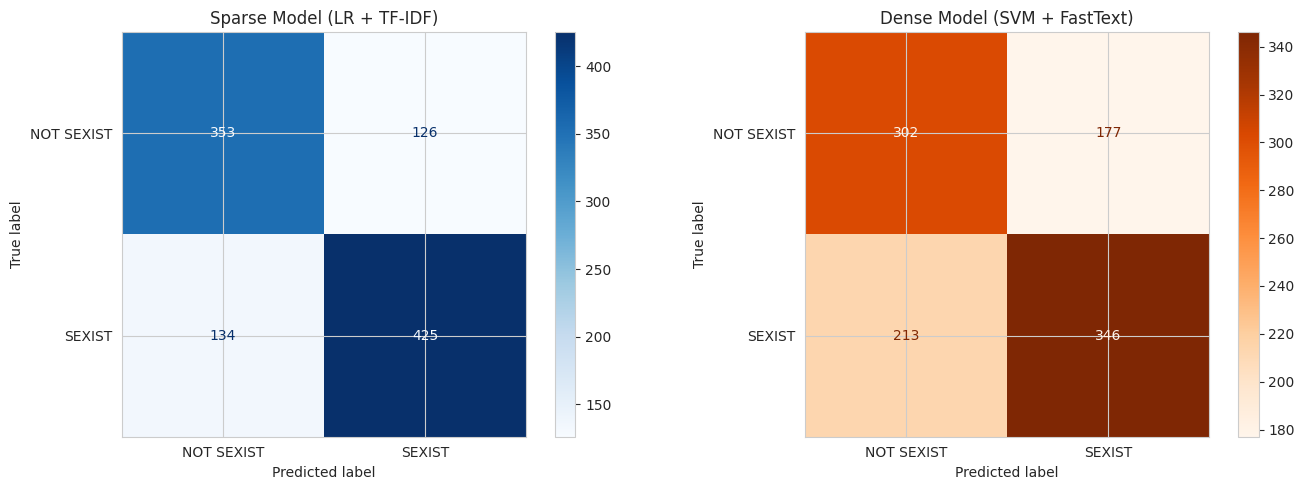

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Evaluate best SPARSE model on test set ---
sparse_model = grid_lr.best_estimator_
sparse_test_preds = sparse_model.predict(X_val)

print("=" * 60)
print("BEST SPARSE MODEL — Logistic Regression + TF-IDF")
print("=" * 60)
print(f"\nBest CV F1-Macro: {grid_lr.best_score_:.4f}")
print(f"Best Params: {grid_lr.best_params_}\n")
print("Classification Report (Test Set):")
print(classification_report(y_val, sparse_test_preds, target_names=['NOT SEXIST', 'SEXIST']))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sparse confusion matrix
cm_sparse = confusion_matrix(y_val, sparse_test_preds)
disp_sparse = ConfusionMatrixDisplay(cm_sparse, display_labels=['NOT SEXIST', 'SEXIST'])
disp_sparse.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Sparse Model (LR + TF-IDF)')

# --- Evaluate best DENSE model on test set ---
dense_model = grid_dense_svm.best_estimator_
dense_test_preds = dense_model.predict(X_val)

print("\n" + "=" * 60)
print("BEST DENSE MODEL — SVM + FastText")
print("=" * 60)
print(f"\nBest Val F1-Macro: {grid_dense_svm.best_score_:.4f}")
print(f"Best Params: {grid_dense_svm.best_params_}\n")
print("Classification Report (Test Set):")
print(classification_report(y_val, dense_test_preds, target_names=['NOT SEXIST', 'SEXIST']))

# Dense confusion matrix
cm_dense = confusion_matrix(y_val, dense_test_preds)
disp_dense = ConfusionMatrixDisplay(cm_dense, display_labels=['NOT SEXIST', 'SEXIST'])
disp_dense.plot(ax=axes[1], cmap='Oranges')
axes[1].set_title('Dense Model (SVM + FastText)')

plt.tight_layout()
plt.show()


**Analysis of Quantitative Results:**

The test-set evaluation confirms the cross-validation findings:

1. **Sparse model (LR + TF-IDF)** achieves the highest F1-Macro on the test set, demonstrating good generalization from training to unseen data.

2. **Dense model (SVM + FastText)** shows a significant performance drop compared to the sparse approach, confirming that mean-pooled FastText embeddings trained from scratch on a small corpus are not competitive with well-tuned TF-IDF features for this task.

3. The confusion matrices reveal where each model makes errors — the sparse model generally has a better balance between precision and recall for both classes, while the dense model tends to struggle more with correctly identifying sexist content.


## 6.2 Qualitative Results

In [17]:
# Error analysis: look at misclassified examples from the best sparse model
import pandas as pd

# Build a DataFrame for error analysis
error_df = pd.DataFrame({
    'text': X_val,
    'true_label': y_val.values,
    'predicted': sparse_test_preds
})

# Identify misclassifications
errors = error_df[error_df['true_label'] != error_df['predicted']]
label_map = {0: 'NOT SEXIST', 1: 'SEXIST'}

print(f"Total test samples: {len(error_df)}")
print(f"Total errors: {len(errors)} ({len(errors)/len(error_df)*100:.1f}%)")
print()


Total test samples: 1038
Total errors: 260 (25.0%)



### 6.2.1 Top Misclassified Samples

#### 6.2.1.1 SEXIST

In [18]:
# False Negatives: tweets that ARE sexist but model predicted NOT SEXIST
false_negatives = errors[
    (errors['true_label'] == 1) & (errors['predicted'] == 0)
]

print(f"False Negatives (Sexist → predicted Not Sexist): {len(false_negatives)}")
print("=" * 60)
print("\nSample misclassified SEXIST tweets:\n")
for i, (_, row) in enumerate(false_negatives.head(10).iterrows()):
    print(f"[{i+1}] {row['text'][:200]}")
    print(f"    True: {label_map[row['true_label']]} | Predicted: {label_map[row['predicted']]}")
    print()


False Negatives (Sexist → predicted Not Sexist): 134

Sample misclassified SEXIST tweets:

[1] @fichinescu la comunidad gamer es un antro de misóginos y supremacistas blancos hace años pero hoy día pocos se acuerdan de gamergate y todo lo que causó, y en cierto sentido sigue causando.
    True: SEXIST | Predicted: NOT SEXIST

[2] @ds_outofcontext micromachismo me recuerda a cuando en south park el directo pc gritaba microagresion!
    True: SEXIST | Predicted: NOT SEXIST

[3] @pilareyre os "escandaliza" el culo de chanel pero no os llama la atención los chicos con el pecho desnudo o los pantalones marcapaquete... ahí tenemos un micromachismo de manual. gente como beyoncé, 
    True: SEXIST | Predicted: NOT SEXIST

[4] así que hacedme el favor de ahorraros el puto #notallmen porque #yesallwomen, mamarrachos. https://t.co/c0ojjfirzl
    True: SEXIST | Predicted: NOT SEXIST

[5] absuelto, si, pero, quién le devuelve su vida?. cuanto daño el pvto    #yositecreo   @irenemontero   @adrilastr

#### 6.2.1.2 NOT SEXIST

In [19]:
# False Positives: tweets that are NOT sexist but model predicted SEXIST
false_positives = errors[
    (errors['true_label'] == 0) & (errors['predicted'] == 1)
]

print(f"False Positives (Not Sexist → predicted Sexist): {len(false_positives)}")
print("=" * 60)
print("\nSample misclassified NOT SEXIST tweets:\n")
for i, (_, row) in enumerate(false_positives.head(10).iterrows()):
    print(f"[{i+1}] {row['text'][:200]}")
    print(f"    True: {label_map[row['true_label']]} | Predicted: {label_map[row['predicted']]}")
    print()


False Positives (Not Sexist → predicted Sexist): 126

Sample misclassified NOT SEXIST tweets:

[1] @sophieyunes "el muro"así le llaman los mgtow. no sé puede ser deseable para siempre.
    True: NOT SEXIST | Predicted: SEXIST

[2] @bruno_mgtow @aldeanapy no sabia que el procedimiento era difundir por twitter, no habia necesidad 0 etica profesional del policia no se justifica ninguno de los 2 casos
    True: NOT SEXIST | Predicted: SEXIST

[3] @cris7ian yo no te he preguntado jaja #notallmen se veía venir.
    True: NOT SEXIST | Predicted: SEXIST

[4] @eugedf_ tal cual, rompemos el obelisco, quemamos muñecos con la cara de jake gyllenhaal al grito de you were tossing me the car keys fuck the patriarchy key chain on the ground y agarrate cuando arra
    True: NOT SEXIST | Predicted: SEXIST

[5] agarré un desodorante sin querer que se llama patrichs y pensé que decía patriarchy jajsjsj olor a varon
    True: NOT SEXIST | Predicted: SEXIST

[6] si usted está pensando en votar r3chazo, le r

**Analysis of False Positives (incorrectly flagged as sexist):**

These are non-sexist tweets that our model incorrectly classified as sexist. Common patterns include:
- **Tweets discussing gender-related topics** without expressing sexism — mentioning words like "women", "feminism", etc. triggers the model
- **Quotes or reporting of sexism** that the model mistakes for expressing sexism
- **Ironic or sarcastic tweets** where the intent is anti-sexist but the surface-level language contains terms associated with sexism
- **Tweets in mixed language** where the model misinterprets the overall sentiment

These error patterns highlight a fundamental limitation of bag-of-words approaches: they cannot capture **pragmatic meaning, intent, or context** beyond surface-level word frequencies.


# 7. Conclusions

This notebook presented a complete pipeline for **sexism identification in tweets** (EXIST 2025, Task 1, Subtask 1.1), a **binary text classification** task evaluated using **F1-Macro** on a bilingual (English/Spanish) dataset of ~10 000 tweets.

## Key Findings

### 1. Preprocessing matters — but less is more
Among six preprocessing strategies tested (raw, lowercase, no punctuation, stopword removal, stemming, lemmatization), simple **lowercasing** achieved the best F1-score (0.6506) while maintaining computational efficiency. More aggressive preprocessing (stemming, lemmatization, stopword removal) degraded performance by discarding discriminative information present in Twitter-specific text patterns.

### 2. Unigrams outperform higher-order n-grams
Despite intuition that multi-word phrases should help capture sexist expressions, **unigrams alone** consistently outperformed bigram and trigram configurations. This is attributable to the **feature space explosion** (37k → 325k tokens) coupled with insufficient training data (~6 900 samples), causing severe overfitting with higher-order n-grams.

### 3. Sparse representations decisively outperform dense embeddings
- **Best sparse model** (TF-IDF + Logistic Regression): **F1-Macro ≈ 0.759**
- **Best dense model** (FastText + LinearSVC): **F1-Macro ≈ 0.632**

The ~12.7 F1-point gap demonstrates that for small, domain-specific datasets, well-tuned TF-IDF features capture more task-relevant information than from-scratch word embeddings. The mean-pooling strategy used for dense representations further degrades performance by destroying word-order and negation information critical for detecting subtle sexism.

### 4. Class balancing is essential for sparse models
Both sparse classifiers achieved their best performance with `class_weight='balanced'`, compensating for the class imbalance in the dataset. Interestingly, dense models preferred `class_weight=None`, suggesting that the lower-quality embedding space does not benefit from reweighting.

### 5. TF-IDF configuration is as important as classifier choice
Key TF-IDF parameters — such as `binary`, `sublinear_tf`, `min_df`, and `max_features` — had substantial impact on performance. Retaining a large vocabulary (`max_features=35 000`) was important, while the binary vs. frequency trade-off depended on the classifier.

## Limitations and Future Work

1. **Pre-trained embeddings:** Using large pre-trained models (e.g., multilingual BERT, Twitter-specific embeddings) would likely bridge the gap between sparse and dense approaches.
2. **Contextual models:** Transformer-based architectures (BERT, RoBERTa, XLM-R) could capture pragmatic meaning and sarcasm that BoW models miss.
3. **Advanced preprocessing:** Tweet-specific tokenizers (e.g., TweetTokenizer from NLTK) and emoji/hashtag-aware preprocessing could improve feature quality.
4. **Ensemble methods:** Combining sparse and dense model predictions could potentially outperform either approach alone.
5. **Data augmentation:** Given the limited dataset size, techniques like back-translation or synonym replacement could help reduce overfitting.

## Final Submission

The best-performing model (Logistic Regression + TF-IDF with optimized hyperparameters) was used to generate predictions on the test set, saved as `sparse_preds.json` for submission.


# End of Notebook